In [1]:
from statsmodels.tsa.ar_model import AutoReg
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv(r"C:\Users\VY72PC\Downloads\pm25_weer.csv")
data

,id,no2,pm10,pm10_cal,pm10_fac,pm10_max,pm10_min,pm25,pm25_cal,pm25_fac,...,YYYYMMDD,jaar,maand,weeknummer,dag,H,T,U,DD,FH
0,1,NaN,8.195,8.774,1.070000,8.39,8.00,4.000,1.640,0.410000,...,20190712,2019,7,28,12,14,173,86,320,60
1,4,NaN,17.258,18.165,1.052000,20.10,15.60,11.176,4.256,0.381000,...,20190712,2019,7,28,12,14,173,86,320,60
2,5,NaN,19.952,20.497,1.027000,24.40,16.50,10.810,3.996,0.370000,...,20190712,2019,7,28,12,14,173,86,320,60
3,7,NaN,20.278,21.216,1.042000,24.40,16.20,11.510,4.292,0.371000,...,20190712,2019,7,28,12,14,173,86,320,60
4,10,NaN,18.099,19.186,1.062000,21.90,14.70,8.942,3.471,0.390000,...,20190712,2019,7,28,12,14,173,86,320,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349808,199,33.4319,24.660,16.796,0.681103,28.50,20.50,11.910,9.877,0.829303,...,20221022,2022,10,42,22,23,127,92,140,20
1349809,200,43.1974,0.000,0.000,NaN,0.00,0.00,0.000,0.000,NaN,...,20221022,2022,10,42,22,23,127,92,140,20
1349810,212,2.5000,23.074,22.407,0.971261,29.30,18.29,7.887,11.534,1.461850,...,20221022,2022,10,42,22,23,127,92,140,20
1349811,213,39.1156,37.694,36.569,0.970257,60.80,24.40,9.182,13.432,1.463180,...,20221022,2022,10,42,22,23,127,92,140,20


In [3]:
data.columns

Index(['id', 'no2', 'pm10', 'pm10_cal', 'pm10_fac', 'pm10_max', 'pm10_min',
       'pm25', 'pm25_cal', 'pm25_fac', 'pm25_max', 'pm25_min', 'timestamp',
       'components', 'latitude', 'longitude', 'name', 'sensortype', 'tag',
       'datum', 'tijd', 'weekdag', 'uur', '#STN', 'YYYYMMDD', 'jaar', 'maand',
       'weeknummer', 'dag', 'H', 'T', 'U', 'DD', 'FH'],
      dtype='object')

In [4]:
data.drop(data.iloc[:, 0:7], axis=1, inplace=True)
data.drop(["jaar", "maand", "weeknummer", "#STN", "timestamp", "components","longitude", "latitude", "dag", "tijd", "datum", "H", "T", "U", "DD", "weekdag", "FH", "sensortype"], axis=1, inplace=True)
data

,pm25,pm25_cal,pm25_fac,pm25_max,pm25_min,name,tag,uur,YYYYMMDD
0,4.000,1.640,0.410000,4.1,3.9,Zuiderkade,Beverwijk,14,20190712
1,11.176,4.256,0.381000,12.4,10.1,Grote Houtweg,Beverwijk,14,20190712
2,10.810,3.996,0.370000,12.3,9.0,Westerhoutplein,Beverwijk,14,20190712
3,11.510,4.292,0.371000,13.9,10.0,Beukenstraat,Beverwijk,14,20190712
4,8.942,3.471,0.390000,10.3,7.3,Parallelweg,Beverwijk,14,20190712
...,...,...,...,...,...,...,...,...,...
1349808,11.910,9.877,0.829303,15.2,10.3,Zuiderkade,Beverwijk,23,20221022
1349809,0.000,0.000,NaN,0.0,0.0,Stationsplein,Beverwijk,23,20221022
1349810,7.887,11.534,1.461850,8.7,7.2,Fluitekruidweg,Zaandam,23,20221022
1349811,9.182,13.432,1.463180,10.5,8.3,Fluitekruidweg,Zaandam,23,20221022


In [5]:
data = data[data.pm25 != 0]
data = data.dropna()
data

,pm25,pm25_cal,pm25_fac,pm25_max,pm25_min,name,tag,uur,YYYYMMDD
0,4.000,1.640,0.410000,4.1,3.9,Zuiderkade,Beverwijk,14,20190712
1,11.176,4.256,0.381000,12.4,10.1,Grote Houtweg,Beverwijk,14,20190712
2,10.810,3.996,0.370000,12.3,9.0,Westerhoutplein,Beverwijk,14,20190712
3,11.510,4.292,0.371000,13.9,10.0,Beukenstraat,Beverwijk,14,20190712
4,8.942,3.471,0.390000,10.3,7.3,Parallelweg,Beverwijk,14,20190712
...,...,...,...,...,...,...,...,...,...
1349807,3.815,3.306,0.865445,6.6,2.7,Schutterskwartier,Heemskerk,23,20221022
1349808,11.910,9.877,0.829303,15.2,10.3,Zuiderkade,Beverwijk,23,20221022
1349810,7.887,11.534,1.461850,8.7,7.2,Fluitekruidweg,Zaandam,23,20221022
1349811,9.182,13.432,1.463180,10.5,8.3,Fluitekruidweg,Zaandam,23,20221022


In [6]:
for i in range(7, len(data.columns)):
    print(f'{data.iloc[:, i].unique()}\n')

[14 15 16 10 11 12 13 17 18 19 20 21 22 23  0  1  2  3  4  5  6  7  8  9]

[20190712 20190718 20191212 ... 20221020 20221021 20221022]



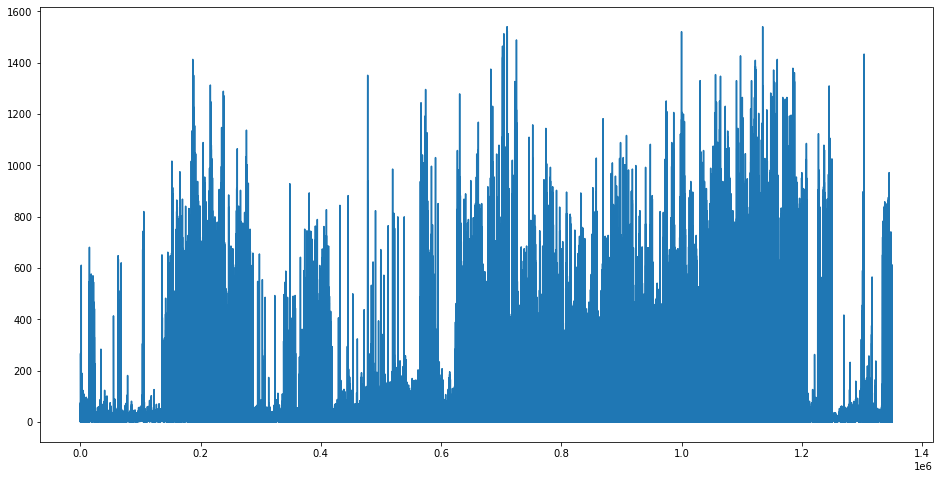

In [7]:
plt.figure(figsize=(16, 8))
plt.plot(data["pm25_cal"])
plt.show()

In [8]:
data = data[data.pm25 < 200]

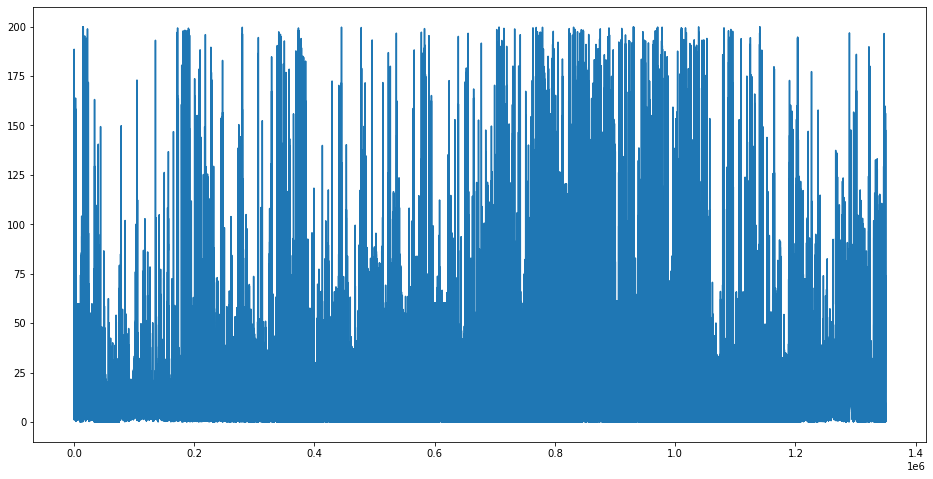

In [9]:
plt.figure(figsize=(16, 8))
plt.plot(data["pm25"])
plt.show()

In [10]:
grouped_df = data.groupby(["YYYYMMDD", "tag"])["pm25"].mean().copy().reset_index()

In [11]:
grouped_df.head(5050)

,YYYYMMDD,tag,pm25
0,20190625,Amsterdam,16.602565
1,20190625,Beverwijk,23.527500
2,20190626,Amsterdam,21.974609
3,20190626,Beverwijk,2.851417
4,20190627,Amsterdam,4.484500
...,...,...,...
5045,20210225,Heemskerk,6.561780
5046,20210225,IJmuiden,5.415112
5047,20210225,Velsen-Noord,6.965722
5048,20210225,Velsen-Zuid,0.848708


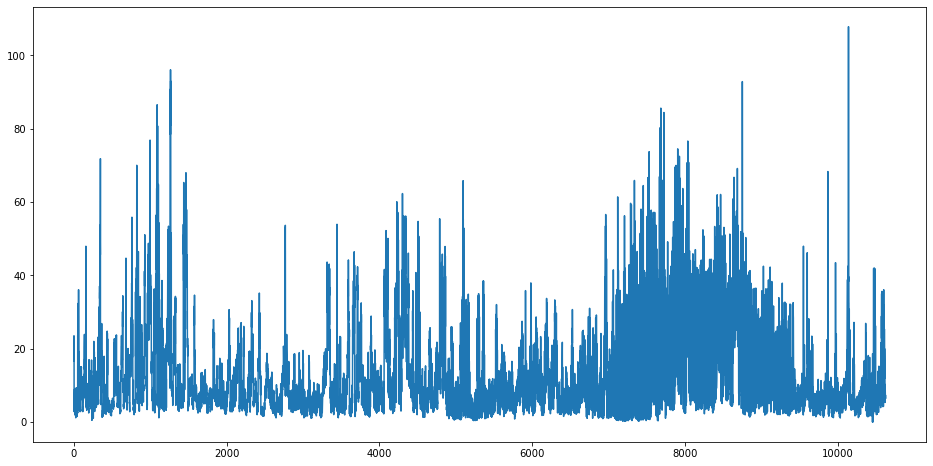

In [12]:
plt.figure(figsize=(16, 8))
plt.plot(grouped_df["pm25"])
plt.show()

In [15]:
data2 = grouped_df.copy()
data2["New"] = data2["YYYYMMDD"].astype(str) #+ "-" +data2["uur"].astype(str)
# del data2["uur"]
del data2["YYYYMMDD"]

In [17]:
data2.set_index("New", inplace=True)

In [18]:
data2

,tag,pm25
New,,
20190625,Amsterdam,16.602565
20190625,Beverwijk,23.527500
20190626,Amsterdam,21.974609
20190626,Beverwijk,2.851417
20190627,Amsterdam,4.484500
...,...,...
20221022,IJmuiden,8.756045
20221022,Uithoorn,7.120000
20221022,Velsen-Noord,6.428708


In [20]:
#create unique list of names
UniqueNames = data2.tag.unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame() for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = data2[:][data2.tag == key]

In [21]:
DataFrameDict["Amsterdam"]

,tag,pm25
New,,
20190625,Amsterdam,16.602565
20190626,Amsterdam,21.974609
20190627,Amsterdam,4.484500
20190628,Amsterdam,7.430917
20190629,Amsterdam,7.474792
...,...,...
20221018,Amsterdam,13.594551
20221019,Amsterdam,11.393981
20221020,Amsterdam,28.333915


  0%|          | 0/11 [00:00<?, ?it/s]

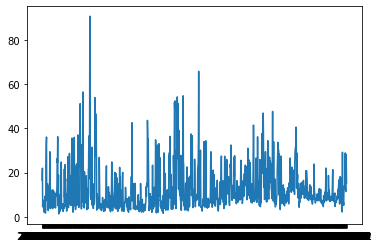

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
  9%|▉         | 1/11 [00:39<06:32, 39.22s/it]

                tag       pm25
New                           
20190625  Amsterdam  16.602565
20190626  Amsterdam  21.974609
20190627  Amsterdam   4.484500
20190628  Amsterdam   7.430917
20190629  Amsterdam   7.474792
...             ...        ...
20221018  Amsterdam  13.594551
20221019  Amsterdam  11.393981
20221020  Amsterdam  28.333915
20221021  Amsterdam  24.523469
20221022  Amsterdam  15.186414

[1195 rows x 2 columns]
                             AutoReg Model Results                             
Dep. Variable:                   pm25   No. Observations:                 1195
Model:                     AutoReg(2)   Log Likelihood               -4182.929
Method:               Conditional MLE   S.D. of innovations              8.063
Date:                Thu, 08 Dec 2022   AIC                              4.181
Time:                        09:41:02   BIC                              4.198
Sample:                             2   HQIC                             4.188
                  

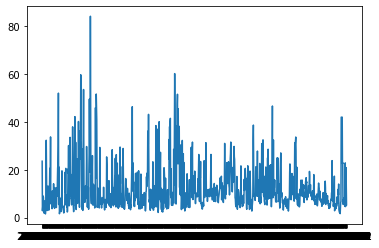

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
 18%|█▊        | 2/11 [01:14<05:30, 36.73s/it]

                tag       pm25
New                           
20190625  Beverwijk  23.527500
20190626  Beverwijk   2.851417
20190627  Beverwijk   4.010603
20190628  Beverwijk   5.533953
20190629  Beverwijk   9.006055
...             ...        ...
20221018  Beverwijk   4.588925
20221019  Beverwijk   5.395958
20221020  Beverwijk  20.864942
20221021  Beverwijk  14.292140
20221022  Beverwijk   5.355000

[1200 rows x 2 columns]
                             AutoReg Model Results                             
Dep. Variable:                   pm25   No. Observations:                 1200
Model:                     AutoReg(2)   Log Likelihood               -4134.688
Method:               Conditional MLE   S.D. of innovations              7.632
Date:                Thu, 08 Dec 2022   AIC                              4.071
Time:                        09:41:37   BIC                              4.088
Sample:                             2   HQIC                             4.078
                  

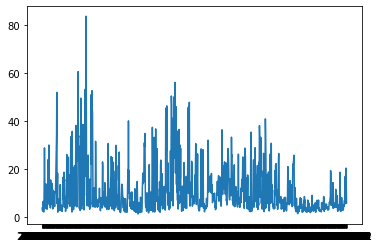

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
 27%|██▋       | 3/11 [01:51<04:57, 37.13s/it]

                tag       pm25
New                           
20190702  Heemskerk   3.702000
20190703  Heemskerk   2.701783
20190704  Heemskerk   2.456625
20190705  Heemskerk   4.618917
20190706  Heemskerk   6.488875
...             ...        ...
20221018  Heemskerk   5.499161
20221019  Heemskerk   6.522591
20221020  Heemskerk  20.398967
20221021  Heemskerk  11.827651
20221022  Heemskerk   5.832736

[1186 rows x 2 columns]
                             AutoReg Model Results                             
Dep. Variable:                   pm25   No. Observations:                 1186
Model:                     AutoReg(2)   Log Likelihood               -4155.671
Method:               Conditional MLE   S.D. of innovations              8.092
Date:                Thu, 08 Dec 2022   AIC                              4.189
Time:                        09:42:14   BIC                              4.206
Sample:                             2   HQIC                             4.195
                  

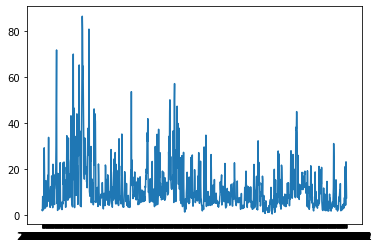

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
 36%|███▋      | 4/11 [02:28<04:17, 36.78s/it]

                   tag       pm25
New                              
20190703  Wijk aan Zee   2.059048
20190704  Wijk aan Zee   1.748930
20190705  Wijk aan Zee   7.951859
20190706  Wijk aan Zee   6.433143
20190707  Wijk aan Zee   2.201536
...                ...        ...
20221018  Wijk aan Zee   4.233794
20221019  Wijk aan Zee   4.263229
20221020  Wijk aan Zee  23.060841
20221021  Wijk aan Zee  13.761896
20221022  Wijk aan Zee   7.388562

[1185 rows x 2 columns]
                             AutoReg Model Results                             
Dep. Variable:                   pm25   No. Observations:                 1185
Model:                     AutoReg(2)   Log Likelihood               -4123.019
Method:               Conditional MLE   S.D. of innovations              7.895
Date:                Thu, 08 Dec 2022   AIC                              4.139
Time:                        09:42:51   BIC                              4.156
Sample:                             2   HQIC              

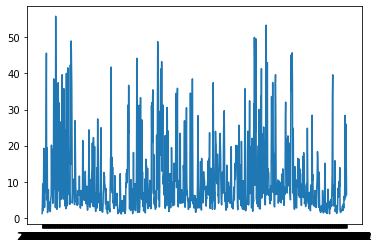

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
 45%|████▌     | 5/11 [03:00<03:30, 35.09s/it]

                   tag       pm25
New                              
20190704  Velsen-Noord   1.178400
20190705  Velsen-Noord   4.580458
20190706  Velsen-Noord   9.383375
20190707  Velsen-Noord   1.942417
20190709  Velsen-Noord   2.450333
...                ...        ...
20221018  Velsen-Noord   5.637824
20221019  Velsen-Noord   6.915667
20221020  Velsen-Noord  25.996136
20221021  Velsen-Noord  16.279917
20221022  Velsen-Noord   6.428708

[1081 rows x 2 columns]
                             AutoReg Model Results                             
Dep. Variable:                   pm25   No. Observations:                 1081
Model:                     AutoReg(2)   Log Likelihood               -3806.812
Method:               Conditional MLE   S.D. of innovations              8.241
Date:                Thu, 08 Dec 2022   AIC                              4.226
Time:                        09:43:23   BIC                              4.244
Sample:                             2   HQIC              

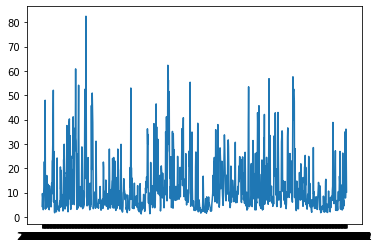

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
 55%|█████▍    | 6/11 [03:34<02:53, 34.78s/it]

               tag       pm25
New                          
20190710  Driehuis   4.333000
20190718  Driehuis   9.629312
20190719  Driehuis   8.041333
20190720  Driehuis   6.714875
20190721  Driehuis   2.978000
...            ...        ...
20221018  Driehuis   7.785098
20221019  Driehuis  11.062278
20221020  Driehuis  36.090788
20221021  Driehuis  25.357472
20221022  Driehuis  10.254000

[1120 rows x 2 columns]
                             AutoReg Model Results                             
Dep. Variable:                   pm25   No. Observations:                 1120
Model:                     AutoReg(2)   Log Likelihood               -4051.982
Method:               Conditional MLE   S.D. of innovations              9.074
Date:                Thu, 08 Dec 2022   AIC                              4.418
Time:                        09:43:57   BIC                              4.436
Sample:                             2   HQIC                             4.425
                               

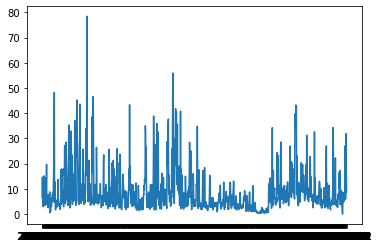

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
 64%|██████▎   | 7/11 [04:26<02:41, 40.35s/it]

               tag       pm25
New                          
20190711  IJmuiden   6.417231
20190712  IJmuiden  14.585263
20190713  IJmuiden   7.761367
20190714  IJmuiden   3.296235
20190715  IJmuiden   3.663917
...            ...        ...
20221018  IJmuiden   5.858405
20221019  IJmuiden   7.833317
20221020  IJmuiden  31.854394
20221021  IJmuiden  20.036064
20221022  IJmuiden   8.756045

[1178 rows x 2 columns]
                             AutoReg Model Results                             
Dep. Variable:                   pm25   No. Observations:                 1178
Model:                     AutoReg(2)   Log Likelihood               -3929.629
Method:               Conditional MLE   S.D. of innovations              6.839
Date:                Thu, 08 Dec 2022   AIC                              3.852
Time:                        09:44:49   BIC                              3.869
Sample:                             2   HQIC                             3.858
                               

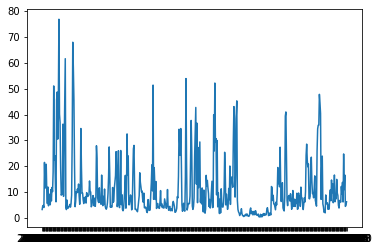

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
 73%|███████▎  | 8/11 [04:45<01:41, 33.71s/it]

                  tag       pm25
New                             
20190919  Velsen-Zuid   3.266273
20190920  Velsen-Zuid   4.705792
20190921  Velsen-Zuid   4.842417
20190922  Velsen-Zuid   4.047222
20190923  Velsen-Zuid  21.498000
...               ...        ...
20220506  Velsen-Zuid  10.986750
20220507  Velsen-Zuid  16.630957
20220508  Velsen-Zuid   4.480583
20220509  Velsen-Zuid   4.944227
20220510  Velsen-Zuid   6.255647

[528 rows x 2 columns]
                             AutoReg Model Results                             
Dep. Variable:                   pm25   No. Observations:                  528
Model:                     AutoReg(2)   Log Likelihood               -1910.399
Method:               Conditional MLE   S.D. of innovations              9.143
Date:                Thu, 08 Dec 2022   AIC                              4.441
Time:                        09:45:08   BIC                              4.474
Sample:                             2   HQIC                            

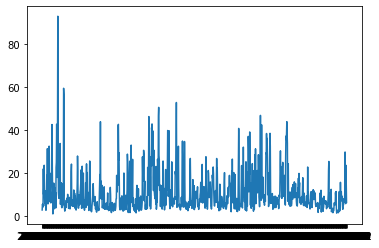

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
 82%|████████▏ | 9/11 [05:22<01:09, 34.71s/it]

              tag       pm25
New                         
20190919  Zaandam   2.993327
20190920  Zaandam   5.623500
20190921  Zaandam   4.987416
20190922  Zaandam   4.347011
20190923  Zaandam  22.093508
...           ...        ...
20221018  Zaandam   7.467459
20221019  Zaandam   5.922350
20221020  Zaandam  23.761873
20221021  Zaandam  13.344158
20221022  Zaandam   6.516025

[1051 rows x 2 columns]
                             AutoReg Model Results                             
Dep. Variable:                   pm25   No. Observations:                 1051
Model:                     AutoReg(2)   Log Likelihood               -3644.818
Method:               Conditional MLE   S.D. of innovations              7.812
Date:                Thu, 08 Dec 2022   AIC                              4.119
Time:                        09:45:45   BIC                              4.138
Sample:                             2   HQIC                             4.126
                                 1051       

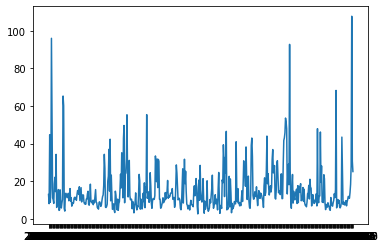

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
 91%|█████████ | 10/11 [05:39<00:29, 29.26s/it]

                       tag        pm25
New                                   
20191011  Koog aan de Zaan   12.908687
20191012  Koog aan de Zaan    8.029304
20191013  Koog aan de Zaan   44.694500
20191014  Koog aan de Zaan    8.774826
20191015  Koog aan de Zaan   16.421500
...                    ...         ...
20220815  Koog aan de Zaan   18.324292
20220816  Koog aan de Zaan   28.257250
20220817  Koog aan de Zaan  107.811833
20220818  Koog aan de Zaan   30.755333
20220819  Koog aan de Zaan   25.134545

[525 rows x 2 columns]
                             AutoReg Model Results                             
Dep. Variable:                   pm25   No. Observations:                  525
Model:                     AutoReg(2)   Log Likelihood               -2007.999
Method:               Conditional MLE   S.D. of innovations             11.251
Date:                Thu, 08 Dec 2022   AIC                              4.856
Time:                        09:46:02   BIC                              

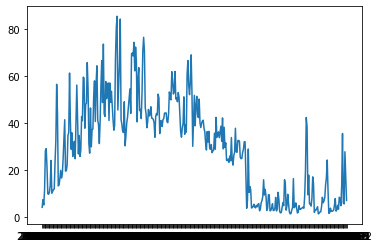

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
100%|██████████| 11/11 [05:53<00:00, 32.16s/it]

               tag       pm25
New                          
20210921  Uithoorn   4.199571
20210922  Uithoorn   7.456667
20210923  Uithoorn   5.208714
20210924  Uithoorn  11.773062
20210925  Uithoorn  28.358850
...            ...        ...
20221018  Uithoorn   5.980941
20221019  Uithoorn   5.646750
20221020  Uithoorn  27.862864
20221021  Uithoorn  17.413708
20221022  Uithoorn   7.120000

[379 rows x 2 columns]
                             AutoReg Model Results                             
Dep. Variable:                   pm25   No. Observations:                  379
Model:                     AutoReg(2)   Log Likelihood               -1377.405
Method:               Conditional MLE   S.D. of innovations              9.343
Date:                Thu, 08 Dec 2022   AIC                              4.491
Time:                        09:46:16   BIC                              4.532
Sample:                             2   HQIC                             4.507
                                

In [22]:
for key in tqdm(DataFrameDict):
    plt.plot(DataFrameDict[key].pm25, label = key)
    plt.show()
    model = AutoReg(DataFrameDict[key].pm25, lags=5).fit()
    print(f'{DataFrameDict[key]}\n', model.summary())